<a href="https://colab.research.google.com/github/Pikarz/tirocinio_infostud/blob/main/MSCRED_dataset_giugno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSCRED - Average dataset
Questo notebook vede come protagonista l'utilizzo del modello MSCRED sul dataset che rappresenta la somma delle latenze per ogni servizio ```phoenixws_requests_delay_sum``` sul numero delle richieste dei medesimi servizi ```phoenixws_requests_delay_count```, generando quindi dataset che rappresenta la latenza media per ogni servizio per un certo timestamp.

# Variables setup

In [ ]:
# extract and save dataframe
dataset_path = 'H:/My Drive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/average_dataset/phoenixws_average_2020-06-13.csv'
labels_path = 'H:/My Drive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/average_dataset/phoenixws_average_2020-06-13_gt.csv'

In [ ]:
# model paths
base_path = "H:/My Drive/Uni/Terzo Anno/Tirocinio/mscred main - phoenixws_average_giugno"
csv_name = 'phoenixws_average_2020-06-13.csv'
csv_filename = 'phoenixws_average_delay_2020-06-13.csv'

# MSCRED

In [ ]:
import numpy as np
import argparse
import pandas as pd
import os, sys
import math
import scipy
#import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import spatial
import itertools as it
import string
import re
import matplotlib.pyplot as plt

def generate_signature_matrix_node(raw_data_path, matrix_data_path, win_sizes, min_time, max_time, gap_time, remove_old_index=False):
    data = np.array(pd.read_csv(csv_path, header=None).loc[1:, :], dtype=np.float64) # the first row contains the timestamps
    if remove_old_index:
      data = np.delete(data, 0, axis=1)
    sensor_n = data.shape[0]

    max_value = np.max(data, axis=1)
    min_value = np.min(data, axis=1)
    data = (np.transpose(data) - min_value) / (max_value - min_value + 1e-6)
    data = np.transpose(data)
    print(f"Original dimensions: {data.shape}")

    if not os.path.exists(matrix_data_path):
      os.makedirs(matrix_data_path)
      print("Created matrix_data_path folder: ",matrix_data_path)

    for win in win_sizes:
        matrix_all = []
        print ("generating signature with window " + str(win) + "...")
        for t in range(min_time, max_time, gap_time):
            matrix_t = np.zeros((sensor_n, sensor_n))
            if t >= max(win_sizes):
                for i in range(sensor_n):
                    for j in range(i, sensor_n):
                        matrix_t[i][j] = np.inner(data[i, t - win:t], data[j, t - win:t]) / (win) # rescale by win
                        matrix_t[j][i] = matrix_t[i][j]
            matrix_all.append(matrix_t)

        path_temp = os.path.join(matrix_data_path, f"matrix_win_{win}.npy")
        np.save(path_temp, matrix_all)
        del matrix_all[:]
    print("matrix generation finish!")

def generate_train_test_data(win_sizes, step_max, gap_time, train_start, train_end, test_start, test_end, matrix_data_path, value_colnames=['total_count', 'error_count', 'error_rate']):
    # Create paths for storing train and test data
    train_data_path = os.path.join(matrix_data_path, "train_data/")
    if not os.path.exists(train_data_path):
        os.makedirs(train_data_path)
    test_data_path = os.path.join(matrix_data_path, "test_data/")
    if not os.path.exists(test_data_path):
        os.makedirs(test_data_path)

    # Load signature matrices for different window sizes and value columns
    data_all = []
    for value_col in value_colnames:
        for win in win_sizes:
            path_temp = os.path.join(matrix_data_path, f"matrix_win_{win}.npy")
            data_all.append(np.load(path_temp))

    # Define time intervals for training and testing
    train_test_time = [[train_start, train_end], [test_start, test_end]]

    # Iterate through train and test time intervals
    for i in range(len(train_test_time)):
        # Iterate through data points within the specified time interval
        for data_id in range(int(train_test_time[i][0] / gap_time), int(train_test_time[i][1] / gap_time)):
            step_multi_matrix = []

            # Generate a sequence of matrices for a specific data point and step
            for step_id in range(step_max, 0, -1):
                multi_matrix = []

                # Combine matrices for different value columns and window sizes
                for k in range(len(value_colnames)):
                    for j in range(len(win_sizes)):
                        multi_matrix.append(data_all[k * len(win_sizes) + j][data_id - step_id])
                step_multi_matrix.append(multi_matrix)

            # Determine whether the data point belongs to training or testing set
            if data_id >= (train_start / gap_time + win_sizes[-1] / gap_time + step_max) and data_id < (train_end / gap_time):
                path_temp = os.path.join(train_data_path, f"train_data_{data_id}")
                np.save(path_temp, step_multi_matrix)
            elif data_id >= (test_start / gap_time) and data_id < (test_end / gap_time):
                path_temp = os.path.join(test_data_path, f"test_data_{data_id}")
                np.save(path_temp, step_multi_matrix)

            # Clear the list for the next iteration
            del step_multi_matrix[:]

    # Print a message when data generation is complete
    print("train/test data generation finish!")

In [ ]:
import numpy as np
import tensorflow as tf
import argparse
import pandas as pd
import os, sys
import timeit
import math
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

def mscred(win_size, step_max, learning_rate,
           training_iters, train_start_id, train_end_id, test_start_id,
           test_end_id, model_path,
           raw_data_path,
           matrix_data_path, train_test_label, save_model_step=1):

    tf.reset_default_graph() # this is in case i run this block multiple times
    train_data_path = os.path.join(matrix_data_path, "train_data/")
    test_data_path = os.path.join(matrix_data_path, "test_data/")
    value_colnames = ['total_count','error_count','error_rate']
    scale_n = len(win_size) * len(value_colnames)
    sensor_n = np.array(pd.read_csv(raw_data_path, header = None).loc[1:, :], dtype=np.float64).shape[0] # the first row contains the timestamps
    print("sensor number: "+str(sensor_n))

    # set GPU
    GPU_id = 0
    os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

    # 4d data
    data_input = tf.placeholder(tf.float32, [step_max, sensor_n, sensor_n, scale_n])

    # parameters: adding bias weight get similar performance
    conv1_W = tf.Variable(tf.zeros([3, 3, scale_n, 32]), name = "conv1_W")
    conv1_W = tf.get_variable("conv1_W", shape = [3, 3, scale_n, 32], initializer=tf.contrib.layers.xavier_initializer())
    conv2_W = tf.Variable(tf.zeros([3, 3, 32, 64]), name = "conv2_W")
    conv2_W = tf.get_variable("conv2_W", shape = [3, 3, 32, 64], initializer=tf.contrib.layers.xavier_initializer())
    conv3_W = tf.Variable(tf.zeros([2, 2, 64, 128]), name = "conv3_W")
    conv3_W = tf.get_variable("conv3_W", shape = [2, 2, 64, 128], initializer=tf.contrib.layers.xavier_initializer())
    conv4_W = tf.Variable(tf.zeros([2, 2, 128, 256]), name = "conv4_W")
    conv4_W = tf.get_variable("conv4_W", shape = [2, 2, 128, 256], initializer=tf.contrib.layers.xavier_initializer())
    # conv5_W = tf.Variable(tf.zeros([2, 2, 256, 256]), name = "conv5_W")
    # conv5_W = tf.get_variable("conv5_W", shape = [2, 2, 256, 256], initializer=tf.contrib.layers.xavier_initializer())

    # this version computes attention weight based on inner-product between feature representation of last step and other steps
    # thus no attenion parameter
    # atten_2_W = tf.Variable(tf.random_normal([64, 32]))
    # atten_3_W = tf.Variable(tf.random_normal([128, 64]))
    # atten_4_W = tf.Variable(tf.random_normal([256, 128]))
    # atten_5_W = tf.Variable(tf.random_normal([256, 128]))

    # deconv5_W = tf.Variable(tf.zeros([2, 2, 256, 256]), name = "deconv5_W")
    # deconv5_W = tf.get_variable("deconv5_W", shape = [2, 2, 256, 256], initializer=tf.contrib.layers.xavier_initializer())
    deconv4_W = tf.Variable(tf.zeros([2, 2, 128, 256]), name = "deconv4_W")
    deconv4_W = tf.get_variable("deconv4_W", shape = [2, 2, 128, 256], initializer=tf.contrib.layers.xavier_initializer())
    deconv3_W = tf.Variable(tf.zeros([2, 2, 64, 256]), name = "deconv3_W")
    deconv3_W = tf.get_variable("deconv3_W", shape = [2, 2, 64, 256], initializer=tf.contrib.layers.xavier_initializer())
    deconv2_W = tf.Variable(tf.zeros([3, 3, 32, 128]), name = "deconv2_W")
    deconv2_W = tf.get_variable("deconv2_W", shape = [3, 3, 32, 128], initializer=tf.contrib.layers.xavier_initializer())
    deconv1_W = tf.Variable(tf.zeros([3, 3, scale_n, 64]), name = "deconv1_W")
    deconv1_W = tf.get_variable("deconv1_W", shape = [3, 3, scale_n, 64], initializer=tf.contrib.layers.xavier_initializer())

    if train_test_label:
      print("Model training")
    else:
      print("Model testing")

    def cnn_encoder(input_matrix):
        conv1 = tf.nn.conv2d(
            input = input_matrix,
            filter = conv1_W,
            strides=(1, 1, 1, 1),
            padding = "SAME")
        conv1 = tf.nn.selu(conv1)

        conv2 = tf.nn.conv2d(
        input = conv1,
        filter = conv2_W,
        strides=(1, 2, 2, 1),
        padding = "SAME")
        conv2 = tf.nn.selu(conv2)

        conv3 = tf.nn.conv2d(
        input = conv2,
        filter = conv3_W,
        strides=(1, 2, 2, 1),
        padding = "SAME")
        conv3 = tf.nn.selu(conv3)

        conv4 = tf.nn.conv2d(
        input = conv3,
        filter = conv4_W,
        strides=(1, 2, 2, 1),
        padding = "SAME")
        conv4 = tf.nn.selu(conv4)

        # conv5 = tf.nn.conv2d(
        #   input = conv4,
        #   filter = conv5_W,
        #   strides=(1, 2, 2, 1),
        #   padding = "SAME")
        # conv5 = tf.nn.selu(conv5)

        #print conv5.get_shape()

        return  conv1, conv2, conv3, conv4

    def conv1_lstm(conv1_out):
        convlstm_layer = tf.contrib.rnn.ConvLSTMCell(
                    conv_ndims = 2,
                    input_shape = [sensor_n, sensor_n, 32],
                    output_channels = 32,
                    kernel_shape = [2, 2],
                    use_bias = True,
                    skip_connection = False,
                    forget_bias = 1.0,
                    initializers = None,
                    name="conv1_lstm_cell")

        outputs, state = tf.nn.dynamic_rnn(convlstm_layer, conv1_out, time_major = False, dtype = conv1_out.dtype)

        # attention based on transformation of feature representation of last step and other steps
        # outputs_mean = tf.reduce_mean(tf.reduce_mean(outputs[0], axis = 1), axis = 1)
        # outputs_mean_W = tf.tanh(tf.matmul(outputs_mean, atten_2_W))
        # outputs_mean_W = tf.matmul(outputs_mean_W, tf.reshape(outputs_mean_W[-1],[32, 1]))/5.0
        # #outputs_mean_W = tf.matmul(outputs_mean_W, atten_2_V)/5.0
        # attention_w = tf.transpose(tf.nn.softmax(outputs_mean_W, dim=0))

        # attention based on inner-product between feature representation of last step and other steps
        attention_w = []
        for k in range(step_max):
            attention_w.append(tf.reduce_sum(tf.multiply(outputs[0][k], outputs[0][-1]))/step_max)
        attention_w = tf.reshape(tf.nn.softmax(tf.stack(attention_w)), [1, step_max])

        outputs = tf.reshape(outputs[0], [step_max, -1])
        outputs = tf.matmul(attention_w, outputs)
        outputs = tf.reshape(outputs, [1, sensor_n, sensor_n, 32])

        return outputs, state[0], attention_w


    def conv2_lstm(conv2_out):
        convlstm_layer = tf.contrib.rnn.ConvLSTMCell(
                    conv_ndims = 2,
                    input_shape = [int(math.ceil(float(sensor_n)/2)), int(math.ceil(float(sensor_n)/2)), 64],
                    output_channels = 64,
                    kernel_shape = [2, 2],
                    use_bias = True,
                    skip_connection = False,
                    forget_bias = 1.0,
                    initializers = None,
                    name="conv2_lstm_cell")

        outputs, state = tf.nn.dynamic_rnn(convlstm_layer, conv2_out, time_major = False, dtype = conv2_out.dtype)

        # attention based on transformation of feature representation of last step and other steps
        # outputs_mean = tf.reduce_mean(tf.reduce_mean(outputs[0], axis = 1), axis = 1)
        # outputs_mean_W = tf.tanh(tf.matmul(outputs_mean, atten_2_W))
        # outputs_mean_W = tf.matmul(outputs_mean_W, tf.reshape(outputs_mean_W[-1],[32, 1]))/5.0
        # #outputs_mean_W = tf.matmul(outputs_mean_W, atten_2_V)/5.0
        # attention_w = tf.transpose(tf.nn.softmax(outputs_mean_W, dim=0))

        # attention based on inner-product between feature representation of last step and other steps
        attention_w = []
        for k in range(step_max):
            attention_w.append(tf.reduce_sum(tf.multiply(outputs[0][k], outputs[0][-1]))/step_max)
        attention_w = tf.reshape(tf.nn.softmax(tf.stack(attention_w)), [1, step_max])

        outputs = tf.reshape(outputs[0], [step_max, -1])
        outputs = tf.matmul(attention_w, outputs)
        outputs = tf.reshape(outputs, [1, int(math.ceil(float(sensor_n)/2)), int(math.ceil(float(sensor_n)/2)), 64])

        return outputs, state[0], attention_w


    def conv3_lstm(conv3_out):
        convlstm_layer = tf.contrib.rnn.ConvLSTMCell(
                    conv_ndims = 2,
                    input_shape = [int(math.ceil(float(sensor_n)/4)), int(math.ceil(float(sensor_n)/4)), 128],
                    output_channels = 128,
                    kernel_shape = [2, 2],
                    use_bias = True,
                    skip_connection = False,
                    forget_bias = 1.0,
                    initializers = None,
                    name="conv3_lstm_cell")

        outputs, state = tf.nn.dynamic_rnn(convlstm_layer, conv3_out, time_major = False, dtype = conv3_out.dtype)

        # outputs_mean = tf.reduce_mean(tf.reduce_mean(outputs[0], axis = 1), axis = 1)
        # outputs_mean_W = tf.tanh(tf.matmul(outputs_mean, atten_3_W))
        # outputs_mean_W = tf.matmul(outputs_mean_W, tf.reshape(outputs_mean_W[-1],[64, 1]))/5.0
        # #outputs_mean_W = tf.matmul(outputs_mean_W, atten_3_V)/5.0
        # attention_w = tf.transpose(tf.nn.softmax(outputs_mean_W, dim=0))

        attention_w = []
        for k in range(step_max):
            attention_w.append(tf.reduce_sum(tf.multiply(outputs[0][k], outputs[0][-1]))/step_max)
        attention_w = tf.reshape(tf.nn.softmax(tf.stack(attention_w)), [1, step_max])

        outputs = tf.reshape(outputs[0], [step_max, -1])
        outputs = tf.matmul(attention_w, outputs)
        outputs = tf.reshape(outputs, [1, int(math.ceil(float(sensor_n)/4)), int(math.ceil(float(sensor_n)/4)), 128])

        return outputs, state[0], attention_w


    def conv4_lstm(conv4_out):
        convlstm_layer = tf.contrib.rnn.ConvLSTMCell(
                    conv_ndims = 2,
                    input_shape = [int(math.ceil(float(sensor_n)/8)), int(math.ceil(float(sensor_n)/8)), 256],
                    output_channels = 256,
                    kernel_shape = [2, 2],
                    use_bias = True,
                    skip_connection = False,
                    forget_bias = 1.0,
                    initializers = None,
                    name="conv4_lstm_cell")

        #initial_state = convlstm_layer.zero_state(batch_size, dtype = tf.float32)
        outputs, state = tf.nn.dynamic_rnn(convlstm_layer, conv4_out, time_major = False, dtype = conv4_out.dtype)

        # outputs_mean = tf.reduce_mean(tf.reduce_mean(outputs[0], axis = 1), axis = 1)
        # outputs_mean_W = tf.tanh(tf.matmul(outputs_mean, atten_4_W))
        # outputs_mean_W = tf.matmul(outputs_mean_W, tf.reshape(outputs_mean_W[-1],[128, 1]))/5.0
        # #outputs_mean_W = tf.matmul(outputs_mean_W, atten_4_V)/5.0
        # attention_w = tf.transpose(tf.nn.softmax(outputs_mean_W, dim=0))

        attention_w = []
        for k in range(step_max):
            attention_w.append(tf.reduce_sum(tf.multiply(outputs[0][k], outputs[0][-1]))/step_max)
        attention_w = tf.reshape(tf.nn.softmax(tf.stack(attention_w)), [1, step_max])

        outputs = tf.reshape(outputs[0], [step_max, -1])
        outputs = tf.matmul(attention_w, outputs)
        outputs = tf.reshape(outputs, [1, int(math.ceil(float(sensor_n)/8)), int(math.ceil(float(sensor_n)/8)), 256])

        return outputs, state[0], attention_w


    def cnn_decoder(conv1_lstm_out, conv2_lstm_out, conv3_lstm_out, conv4_lstm_out):
        conv1_lstm_out = tf.reshape(conv1_lstm_out, [1, sensor_n, sensor_n, 32])
        conv2_lstm_out = tf.reshape(conv2_lstm_out, [1, int(math.ceil(float(sensor_n)/2)), int(math.ceil(float(sensor_n)/2)), 64])
        conv3_lstm_out = tf.reshape(conv3_lstm_out, [1, int(math.ceil(float(sensor_n)/4)), int(math.ceil(float(sensor_n)/4)), 128])
        conv4_lstm_out = tf.reshape(conv4_lstm_out, [1, int(math.ceil(float(sensor_n)/8)), int(math.ceil(float(sensor_n)/8)), 256])
        #conv5_lstm_out = tf.reshape(conv5_lstm_out, [1, int(math.ceil(float(sensor_n)/16)), int(math.ceil(float(sensor_n)/16)), 256])

        # deconv5 = tf.nn.conv2d_transpose(
        #   value = conv5_lstm_out,
        #   filter = deconv5_W,
        #   output_shape = [1, int(math.ceil(float(sensor_n)/8)), int(math.ceil(float(sensor_n)/8)), 256],
        #   strides = (1, 2, 2, 1),
        #   padding = "SAME")
        # deconv5 = tf.nn.selu(deconv5)
        # deconv5_concat = tf.concat([deconv5, conv4_lstm_out], axis = 3)

        deconv4 = tf.nn.conv2d_transpose(
        value = conv4_lstm_out,
        filter = deconv4_W,
        output_shape = [1, int(math.ceil(float(sensor_n)/4)), int(math.ceil(float(sensor_n)/4)), 128],
        strides = (1, 2, 2, 1),
        padding = "SAME")
        deconv4 = tf.nn.selu(deconv4)
        deconv4_concat = tf.concat([deconv4, conv3_lstm_out], axis = 3)

        deconv3 = tf.nn.conv2d_transpose(
        value = deconv4_concat,
        filter = deconv3_W,
        output_shape = [1, int(math.ceil(float(sensor_n)/2)), int(math.ceil(float(sensor_n)/2)), 64],
        strides = (1, 2, 2, 1),
        padding = "SAME")
        deconv3 = tf.nn.selu(deconv3)
        deconv3_concat = tf.concat([deconv3, conv2_lstm_out], axis = 3)

        deconv2 = tf.nn.conv2d_transpose(
        value = deconv3_concat,
        filter = deconv2_W,
        output_shape = [1, sensor_n, sensor_n, 32],
        strides = (1, 2, 2, 1),
        padding = "SAME")
        deconv2 = tf.nn.selu(deconv2)

        deconv2_concat = tf.concat([deconv2, conv1_lstm_out], axis = 3)

        deconv1 = tf.nn.conv2d_transpose(
        value = deconv2_concat,
        filter = deconv1_W,
        output_shape = [1, sensor_n, sensor_n, scale_n],
        strides = (1, 1, 1, 1),
        padding = "SAME")
        deconv1 = tf.nn.selu(deconv1)
        deconv1 = tf.reshape(deconv1, [1, sensor_n, sensor_n, scale_n])
        return deconv1


    conv1_out, conv2_out, conv3_out, conv4_out = cnn_encoder(data_input)
    conv1_out = tf.reshape(conv1_out, [-1, step_max, sensor_n, sensor_n, 32])
    conv2_out = tf.reshape(conv2_out, [-1, step_max, int(math.ceil(float(sensor_n)/2)), int(math.ceil(float(sensor_n)/2)), 64])
    conv3_out = tf.reshape(conv3_out, [-1, step_max, int(math.ceil(float(sensor_n)/4)), int(math.ceil(float(sensor_n)/4)), 128])
    conv4_out = tf.reshape(conv4_out, [-1, step_max, int(math.ceil(float(sensor_n)/8)), int(math.ceil(float(sensor_n)/8)), 256])

    conv1_lstm_attention_out, conv1_lstm_last_out, atten_weight_1 = conv1_lstm(conv1_out)
    conv2_lstm_attention_out, conv2_lstm_last_out, atten_weight_2 = conv2_lstm(conv2_out)
    conv3_lstm_attention_out, conv3_lstm_last_out, atten_weight_3 = conv3_lstm(conv3_out)
    conv4_lstm_attention_out, conv4_lstm_last_out, atten_weight_4 = conv4_lstm(conv4_out)

    deconv_out = cnn_decoder(conv1_lstm_attention_out, conv2_lstm_attention_out, conv3_lstm_attention_out, conv4_lstm_attention_out)

    # loss function: reconstruction error of last step matrix
    loss = tf.reduce_mean(tf.square(data_input[-1] - deconv_out))
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

    init = tf.global_variables_initializer()
    saver = tf.train.Saver(max_to_keep = 10)

    starting_iter = 0
    if train_test_label: # model training
        with tf.Session(config=tf.ConfigProto(inter_op_parallelism_threads=80, intra_op_parallelism_threads=80)) as sess:
            if starting_iter == 0:
                sess.run(init)
            else:
                saver.restore(sess, model_path + str(starting_iter-1) + ".ckpt")
            start = timeit.default_timer()
            for idx in range(starting_iter, starting_iter+training_iters):
                print ("training iteration " + str(idx) + "...")
                for train_id in range(train_start_id, train_end_id):
                    matrix_data_path = train_data_path + "train_data_" + str(train_id) + ".npy"
                    matrix_gt = np.load(matrix_data_path)
                    matrix_gt = np.transpose(matrix_gt, (0, 2, 3, 1))

                    feed_dict = {data_input: np.asarray(matrix_gt)}
                    a, loss_value = sess.run([optimizer, loss], feed_dict)

                    # if train_id % 50 == 0:
                    # 	save_path = saver.save(sess, model_path + str(idx * 15 + train_id/50) + ".ckpt")

                if idx % save_model_step == 0:
                    if not os.path.exists(model_path):
                        os.makedirs(model_path)
                    save_path = saver.save(sess, model_path + str(idx) + ".ckpt")
                    print ("mse of last train data: " + str(loss_value))

            stop = timeit.default_timer()

            print(str(training_iters) + " iterations training finish, use time: " + str(stop - start))

    else: # train_test_label=False # model test
        learning_curve = open(model_path+"/learning_curve.csv", "w")

        with tf.Session(config=tf.ConfigProto(inter_op_parallelism_threads=20, intra_op_parallelism_threads=20)) as sess:
            restore_idx = 0 # setting restore_idx of learned model
            saver.restore(sess, model_path + str(restore_idx) + ".ckpt")

            reconstructed_data_path = matrix_data_path + "reconstructed_data/"
            if not os.path.exists(reconstructed_data_path):
                os.makedirs(reconstructed_data_path)

            print ("model test: generate reconstructed matrices"+ "...")
            loss_value_ave = 0
            for test_id in range(test_start_id, test_end_id):
                matrix_data_path = test_data_path + 'test_data_' + str(test_id) + ".npy"
                matrix_gt = np.load(matrix_data_path)
                matrix_gt = np.transpose(matrix_gt, (0, 2, 3, 1))

                feed_dict = {data_input: np.asarray(matrix_gt)}
                reconstructed_matrix = sess.run([deconv_out], feed_dict)

                loss_value = sess.run([loss], feed_dict)
                loss_value_ave += loss_value[0]
                #print(loss_value)

                path_temp = os.path.join(reconstructed_data_path, 'reconstructed_data_' + str(test_id) + ".npy")
                np.save(path_temp, np.asarray(reconstructed_matrix))

                learning_curve.write("%lf\n"%(loss_value_ave/789))
                #print(loss_value_ave/10000)
                #print(str(i*50) + "\t" + str(loss_value_ave/600))
            print ("reconstructed matrices generation finish.")

        learning_curve.close()


In [ ]:
# Function to calculate anomaly scores
def calculate_anomaly_scores(test_data_path, reconstructed_data_path, thred_b, valid_start, valid_end, test_start, test_end):
    # Initialize arrays to store anomaly scores
    valid_anomaly_score = np.zeros((valid_end - valid_start , 1))
    test_anomaly_score = np.zeros((test_end - test_start, 1))

    # Loop over time steps
    for i in range(valid_start, test_end):
        # Load ground truth matrix and reconstructed matrix
        path_temp_1 = os.path.join(test_data_path, "test_data_" + str(i) + '.npy')
        gt_matrix_temp = np.load(path_temp_1)

        path_temp_2 = os.path.join(reconstructed_data_path, "reconstructed_data_" + str(i) + '.npy')
        reconstructed_matrix_temp = np.load(path_temp_2)
        reconstructed_matrix_temp = np.transpose(reconstructed_matrix_temp[0], [0, 3, 1, 2])

        # Select relevant matrices
        select_gt_matrix = np.array(gt_matrix_temp)[4][0]
        select_reconstructed_matrix = np.array(reconstructed_matrix_temp)[0][0]

        # Compute matrix error and count broken elements
        select_matrix_error = np.square(np.subtract(select_gt_matrix, select_reconstructed_matrix))
        num_broken = len(select_matrix_error[select_matrix_error > thred_b])

        # Store anomaly score in appropriate array
        if i < valid_end:
            valid_anomaly_score[i - valid_start] = num_broken
        else:
            test_anomaly_score[i - test_start] = num_broken

    # Compute maximum anomaly score for validation set
    valid_anomaly_max = np.max(valid_anomaly_score.ravel())
    # Flatten test anomaly scores array
    test_anomaly_score = test_anomaly_score.ravel()

    return valid_anomaly_score, test_anomaly_score

# Function to plot anomaly scores
def plot_anomaly_scores(test_anomaly_score, valid_anomaly_max, alpha, test_start, test_end, true_test_labels=None):
    # Create a figure
    fig, axes = plt.subplots(figsize=(20, 10))
    plt.xticks(fontsize=25)
    plt.xlim(0, len(test_anomaly_score) - 1)
    plt.ylim((0, np.max(test_anomaly_score)+(1/100*np.max(test_anomaly_score))))
    plt.yticks(np.arange(0, np.max(test_anomaly_score), 20), fontsize=25)

    # Plot test anomaly scores
    plt.plot(test_anomaly_score, 'b', linewidth=2, label='Anomaly Score')
    threshold = np.full((test_end - test_start), valid_anomaly_max * alpha)

    # Plot threshold line
    axes.plot(threshold, color='black', linestyle='--', linewidth=2, label='Threshold')

    # Plot true test labels when they are equal to 1
    if true_test_labels is not None:
        true_indices = np.where(true_test_labels == 1)[0]
        true_values = test_anomaly_score[true_indices]
        plt.scatter(true_indices, true_values, color='darkred', s=50, label='True Anomalies')

    plt.xlabel('Test Time', fontsize=25)
    plt.ylabel('Anomaly Score', fontsize=25)
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.yaxis.set_ticks_position('left')
    axes.xaxis.set_ticks_position('bottom')
    fig.subplots_adjust(bottom=0.25)
    fig.subplots_adjust(left=0.25)
    plt.title("MSCRED", size=25)

    # Add legend
    plt.legend(fontsize=20)

    plt.show()

import plotly.express as px
import plotly.graph_objs as go
import pandas as pd
import numpy as np

def save_anomaly_scores_plot(test_anomaly_score, valid_anomaly_max, alpha, test_start, test_end, true_test_labels=None, filename="anomaly_plot.html"):
    # Create a DataFrame for the test anomaly scores
    df = pd.DataFrame({'Test Time': range(len(test_anomaly_score.ravel())), 'Anomaly Score': test_anomaly_score.ravel()})

    # Create the figure using Plotly Express
    fig = px.line(df, x='Test Time', y=['Anomaly Score'], title='MSCRED')

    # Convert the Plotly Express figure to a Graph Object figure
    fig = go.Figure(fig)


    if true_test_labels is not None:
        true_indices = np.where(true_test_labels == True)[0]
        if len(true_indices) > 0:
            # Create a list of x-values for the "True Anomalies" area
            x = df.loc[true_indices, 'Test Time'].tolist()

            # Create a list of y-values for the "True Anomalies" area
            y = df.loc[true_indices, 'Anomaly Score'].tolist()

            # Add the "True Anomalies" area to the figure
            fig.add_trace(go.Scatter(x=x, y=y, fill='tozeroy', mode='none', name='True Anomalies'))

    # Add threshold line
    threshold = valid_anomaly_max * alpha
    threshold_trace = go.Scatter(
        x=[0, len(test_anomaly_score.ravel())],
        y=[threshold, threshold],
        mode='lines',
        line=dict(color='black', width=2, dash='dash'),
        name='Threshold'
    )

    # Add the threshold trace to the figure
    fig.add_trace(threshold_trace)

    # Increase font size for x and y-axis labels
    fig.update_xaxes(title_text='Test Time', tickfont=dict(size=26), title_font=dict(size=26))
    fig.update_yaxes(title_text='Anomaly Score', tickfont=dict(size=26), title_font=dict(size=26))

    # Show the legend and increase font size
    fig.update_layout(legend=dict(title='Legenda', font=dict(size=26)))

    # Save the plot as an HTML file
    fig.write_html(filename)


# Estrazione dati, preparazione per MSCRED e salvataggio dati

I successivi blocchi di codice vedono l'estrazione del dataset, la sua normalizzazione, il plot dei dati normalizzati e la creazione delle sue etichette ground-truth

In [ ]:
def calculate_anomaly_percentage(ground_truth):
    num_anomalies = np.sum(ground_truth)
    total_samples = len(ground_truth)
    anomaly_percentage = (num_anomalies / total_samples) * 100
    return anomaly_percentage

In [ ]:
# estrazione

columns = ['phoenixws_average_'+str(i) for i in range(12)]
average_df = pd.read_csv(dataset_path, names=columns)
average_df.index.name = 'time'

In [ ]:
average_df

,phoenixws_average_0,phoenixws_average_1,phoenixws_average_2,phoenixws_average_3,phoenixws_average_4,phoenixws_average_5,phoenixws_average_6,phoenixws_average_7,phoenixws_average_8,phoenixws_average_9,phoenixws_average_10,phoenixws_average_11
time,,,,,,,,,,,,
0,226.256331,157.042704,650.150822,NaN,NaN,93.292070,122.922180,108.291494,93.719837,NaN,115.017592,78.525908
1,114.649705,156.027159,85.176111,NaN,NaN,77.420154,105.931374,96.814403,101.692592,5117.759914,141.264370,81.637110
2,162.071430,190.675924,83.173392,NaN,NaN,74.057970,107.580199,85.951839,96.113135,5020.346545,114.791776,84.136558
3,145.125408,138.352197,92.390675,NaN,NaN,74.495387,101.839034,98.196607,108.615769,157.087626,111.519098,77.213577
4,174.599262,179.686673,105.739640,NaN,NaN,99.715896,92.114295,96.298119,115.352263,6432.994237,NaN,88.032437
...,...,...,...,...,...,...,...,...,...,...,...,...
48332,NaN,NaN,NaN,149.269297,1489.275460,85.859455,124.470640,99.188524,100.255517,1273.153954,301.375413,127.288044
48333,NaN,NaN,NaN,158.823013,341.200658,95.688347,93.556163,91.164547,91.695597,477.878807,111.846473,84.207457
48334,NaN,NaN,NaN,144.767174,383.106111,83.622418,103.469632,95.572778,91.920055,162.809894,107.771521,86.501452


In [ ]:
# normalizzazione
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
average_df_normalized = pd.DataFrame(scaler.fit_transform(average_df), index=average_df.index, columns=average_df.columns)

In [ ]:
# fill NaN values
#average_df_normalized.interpolate(method='linear', axis=0, inplace=True)
average_df_normalized.fillna(average_df_normalized.mean(), inplace=True)
average_df_normalized

,phoenixws_average_0,phoenixws_average_1,phoenixws_average_2,phoenixws_average_3,phoenixws_average_4,phoenixws_average_5,phoenixws_average_6,phoenixws_average_7,phoenixws_average_8,phoenixws_average_9,phoenixws_average_10,phoenixws_average_11
time,,,,,,,,,,,,
0,0.006884,0.004180,0.023902,0.008545,0.021109,0.001596,0.001836,0.002185,0.001606,0.043084,0.002459,0.001009
1,0.002441,0.004139,0.001293,0.008545,0.021109,0.000960,0.001156,0.001725,0.001925,0.202832,0.003510,0.001133
2,0.004329,0.005526,0.001213,0.008545,0.021109,0.000825,0.001222,0.001290,0.001702,0.198930,0.002450,0.001234
3,0.003654,0.003432,0.001582,0.008545,0.021109,0.000843,0.000992,0.001781,0.002203,0.004148,0.002318,0.000956
4,0.004828,0.005086,0.002116,0.008545,0.021109,0.001854,0.000602,0.001704,0.002473,0.255509,0.016887,0.001390
...,...,...,...,...,...,...,...,...,...,...,...,...
48332,0.016904,0.016827,0.013561,0.003819,0.057380,0.001298,0.001898,0.001820,0.001868,0.048849,0.009926,0.002963
48333,0.016904,0.016827,0.013561,0.004202,0.011486,0.001692,0.000660,0.001499,0.001525,0.016997,0.002332,0.001236
48334,0.016904,0.016827,0.013561,0.003639,0.013161,0.001209,0.001057,0.001675,0.001534,0.004378,0.002168,0.001328


In [ ]:
# estrazione

columns = ['label']
labels_df = pd.read_csv(labels_path, names=columns)
labels_df.index.name = 'time'
#common_indices = labels_df.index.isin(average_df_normalized.index)
#labels_df = labels_df[common_indices]
labels_df

,label
time,
0,False
1,False
2,False
3,False
4,False
...,...
48332,False
48333,False
48334,False


In [ ]:
labels_df[labels_df['label']==True] # anomalies

,label
time,
1683,True
1684,True
1685,True
1686,True
1687,True
...,...
34435,True
34436,True
34437,True


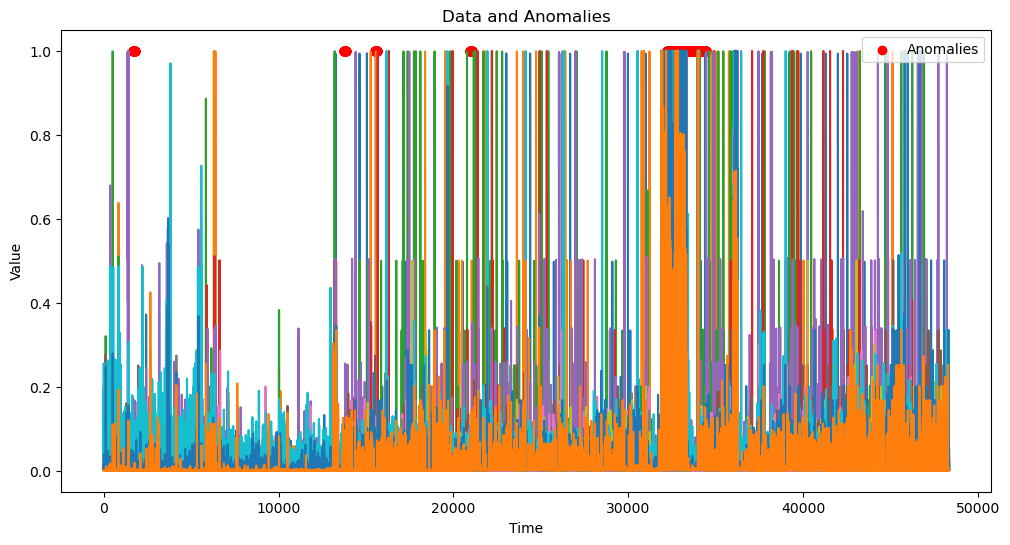

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

merged_df = pd.merge(average_df_normalized, labels_df, on="time", how="inner")
highlighted_points = merged_df[merged_df["label"] == 1]
plt.figure(figsize=(12, 6))
plt.plot(average_df_normalized)
plt.scatter(highlighted_points.index, highlighted_points["label"], color="red", label="Anomalies")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Data and Anomalies")
plt.show()

In [ ]:
df_ready = average_df_normalized.T # matrix_generator wants each column to be an observation
df_ready.reset_index(drop=True, inplace=True)# Reset the index to start from 0 and drop the current index

In [ ]:
import os

# Specify the directory path where you want to save the CSV file
save_directory = os.path.join(base_path, 'input_data/')

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Save the DataFrame to a CSV file in the specified directory
csv_path = os.path.join(save_directory, csv_filename)
df_ready.to_csv(csv_path, index=False)

print(f"DataFrame saved to {csv_path}")

DataFrame saved to H:/My Drive/Uni/Terzo Anno/Tirocinio/mscred main - phoenixws_average_giugno\input_data/phoenixws_average_delay_2020-06-13.csv


# reshape labels

In [ ]:
import numpy as np

def fill_to_divisible(arr, win):
    # Calculate the number of elements needed to make the array divisible by win
    remainder = len(arr) % win
    if remainder != 0:
        num_to_fill = win - remainder
        fill_values = np.array([False] * num_to_fill, dtype=bool)
        arr = np.concatenate((arr, fill_values))
    return arr

def accorpate_last_values(arr):
  arr[-2] = np.any([arr[-1], arr[-2]])
  return arr[:-1]

In [ ]:
def get_train_end_valid_end(train_start, label_values, train_split_index, valid_split_index):
  train_end = train_start + int(len(label_values)*train_split_index)
  valid_end = train_start + int(len(labels_df)*(train_split_index+valid_split_index))
  return train_end, valid_end

In [ ]:
def reshape_labels(labels_df, win, train_start, train_split_index, valid_split_index):

  label_values = labels_df['label'].values

  original_train_end, original_valid_end = get_train_end_valid_end(train_start, label_values, train_split_index, valid_split_index)
  train_labels = label_values[:original_train_end]
  valid_labels = label_values[original_train_end:original_valid_end]
  test_labels = label_values[original_valid_end:]

  reshaped_train_labels = fill_to_divisible(train_labels, win).reshape(-1, win)
  reshaped_valid_labels = fill_to_divisible(valid_labels, win).reshape(-1, win)
  reshaped_test_labels = fill_to_divisible(test_labels, win).reshape(-1, win)

  true_train_labels = accorpate_last_values(np.any(reshaped_train_labels, axis=1).astype(int))
  true_valid_labels = accorpate_last_values(np.any(reshaped_valid_labels, axis=1).astype(int))
  true_test_labels = accorpate_last_values(np.any(reshaped_test_labels, axis=1).astype(int))

  valid_start = true_train_labels.shape[0]
  valid_end = valid_start + true_valid_labels.shape[0]
  test_start = valid_end
  test_end = test_start + true_test_labels.shape[0]
  total_samples = true_train_labels.shape[0] + true_valid_labels.shape[0] + true_test_labels.shape[0]

  percentage_train = true_train_labels.shape[0] / total_samples
  percentage_valid = true_valid_labels.shape[0] / total_samples
  percentage_test = true_test_labels.shape[0] / total_samples

  percentage_anomaly_train = calculate_anomaly_percentage(true_train_labels)
  percentage_anomaly_valid = calculate_anomaly_percentage(true_valid_labels)
  percentage_anomaly_test = calculate_anomaly_percentage(true_test_labels)

  print(f"Split: train {percentage_train}, valid {percentage_valid}, test {percentage_test}")
  print(f"Percentage anomaly train ground-truth set: {percentage_anomaly_train}\nPercentage anomaly validation ground-truth set: {percentage_anomaly_valid}\nPercentage anomaly test ground-truth set: {percentage_anomaly_test}")

  return true_train_labels, true_valid_labels, true_test_labels, valid_start, valid_end, test_start, test_end

In [ ]:
def get_first_and_last_files(directory):
    # Get a list of files in the directory
    files = os.listdir(directory)

    # Sort the list of files alphabetically
    sorted_files = sorted(files)

    # Get the first and last files
    first_file = sorted_files[0] if sorted_files else None
    last_file = sorted_files[-1] if sorted_files else None

    return first_file, last_file

In [ ]:
import os

def get_first_and_last_index(directory):
    def extract_index(filename):
        try:
            return int(filename.split('_')[2].split('.')[0])
        except ValueError:
            return None

    filenames = [filename for filename in os.listdir(directory) if filename.endswith('.npy')]
    filenames_with_indices = [(filename, extract_index(filename)) for filename in filenames if extract_index(filename) is not None]

    if not filenames_with_indices:
        return None, None

    sorted_filenames = sorted(filenames_with_indices, key=lambda x: x[1])
    first_file, first_index = sorted_filenames[0]
    last_file, last_index = sorted_filenames[-1]

    last_index += 1 # when indexing with [:last_index], the last index is not included. I need the last value too.

    return first_index, last_index

# MSCRED - matrix_generator

In [ ]:
import os

input_data_path = os.path.join(base_path, 'input_data/')
raw_data_path = os.path.join(input_data_path, csv_name)
matrix_data_path = os.path.join(base_path, 'matrix_generator_output', 'data')
mscred_output_path = os.path.join(base_path, 'mscred_output/')
columns = ['label']
labels_df = pd.read_csv(labels_path, names=columns)

In [ ]:
train_split_index = 0.50
valid_split_index = 0.182
test_split_index = 0.318

win_sizes = [30, 60, 120]
min_time = 0
max_time = labels_df.shape[0]
gap_time = min(win_sizes)
step_max = 20
train_start = 0
train_end, _ = get_train_end_valid_end(train_start, labels_df, train_split_index, valid_split_index)
test_start = train_end
test_end = max_time

In [ ]:
true_train_labels, true_valid_labels, true_test_labels, _, _, _, _ = reshape_labels(labels_df, min(win_sizes), train_start, train_split_index, valid_split_index)

Split: train 0.5, valid 0.18198757763975154, test 0.31801242236024846
Percentage anomaly train ground-truth set: 2.484472049689441
Percentage anomaly validation ground-truth set: 8.532423208191126
Percentage anomaly test ground-truth set: 9.765625


In [ ]:
generate_signature_matrix_node(raw_data_path, matrix_data_path, win_sizes, min_time, max_time, gap_time)

Original dimensions: (12, 48337)
Created matrix_data_path folder:  H:/My Drive/Uni/Terzo Anno/Tirocinio/mscred main - phoenixws_average_giugno\matrix_generator_output\data
generating signature with window 30...
generating signature with window 60...
generating signature with window 120...
matrix generation finish!


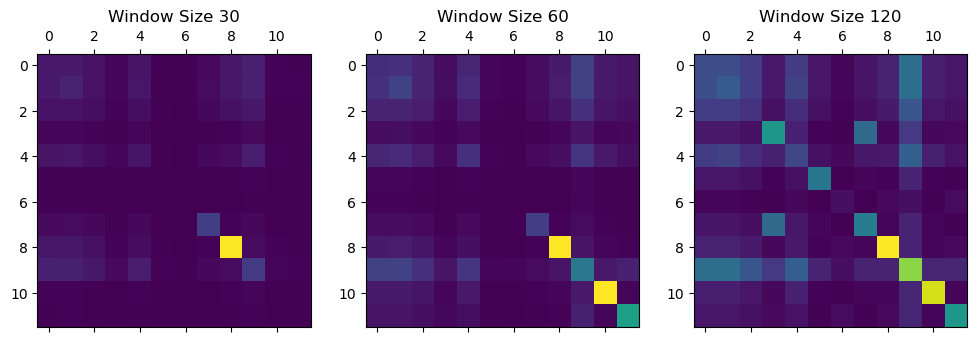

In [ ]:
# an example of 3 sm
fig, ax = plt.subplots(1, len(win_sizes), figsize=(len(win_sizes)*4, 4))

for i, win_size in enumerate(win_sizes):
    matrix_path = os.path.join(matrix_data_path, f'matrix_win_{win_size}.npy')
    matrix = np.load(matrix_path)
    ax[i].matshow(matrix[-1])
    ax[i].set_title(f'Window Size {win_size}')

plt.show()

In [ ]:
generate_train_test_data(win_sizes, step_max, gap_time, train_start, train_end, test_start, test_end, matrix_data_path)

train/test data generation finish!


# MSCRED


In [ ]:
learning_rate = 0.0002 # same as the original implementation
training_iters = 7

train_start_id, train_end_id = get_first_and_last_index(matrix_data_path+'/train_data')
test_start_id, test_end_id = get_first_and_last_index(matrix_data_path+'/test_data')

model_path = os.path.join(base_path, 'mscred_output/')

In [ ]:
mscred(
        win_size=win_sizes, step_max=step_max, learning_rate=learning_rate,
        raw_data_path=csv_path, matrix_data_path=matrix_data_path,
        training_iters=training_iters,
        train_start_id=train_start_id, train_end_id=train_end_id, test_start_id=test_start_id, test_end_id=test_end_id,
        model_path=model_path, train_test_label=1
      )

sensor number: 12
Model training
training iteration 0...
mse of last train data: 2.7326715e-07
training iteration 1...
mse of last train data: 2.6693095e-07
training iteration 2...
mse of last train data: 2.6379124e-07
training iteration 3...
mse of last train data: 2.655584e-07
training iteration 4...
mse of last train data: 2.6959418e-07
training iteration 5...
mse of last train data: 2.679412e-07
training iteration 6...
mse of last train data: 2.712504e-07
7 iterations training finish, use time: 1021.7590241


In [ ]:
mscred(
        win_size=win_sizes, step_max=step_max, learning_rate=learning_rate,
        raw_data_path=csv_path, matrix_data_path=matrix_data_path,
        training_iters=training_iters,
        train_start_id=train_start_id, train_end_id=train_end_id, test_start_id=test_start_id, test_end_id=test_end_id,
        model_path=model_path, train_test_label=0
      )

sensor number: 12
Model testing
INFO:tensorflow:Restoring parameters from H:/My Drive/Uni/Terzo Anno/Tirocinio/mscred main - phoenixws_average_giugno\mscred_output/0.ckpt
model test: generate reconstructed matrices...
reconstructed matrices generation finish.


# Explore output

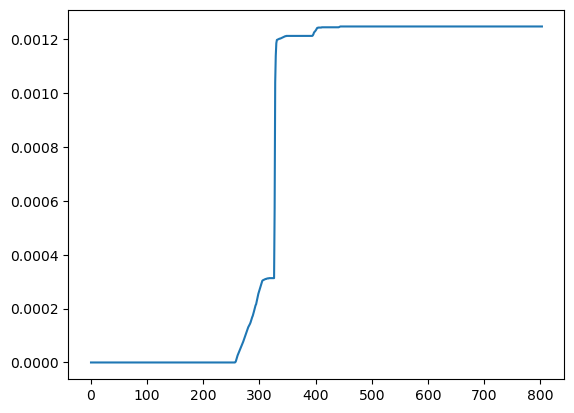

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

learning_curve = pd.read_csv(os.path.join(model_path, 'learning_curve.csv'))
plt.plot(learning_curve)
plt.show()

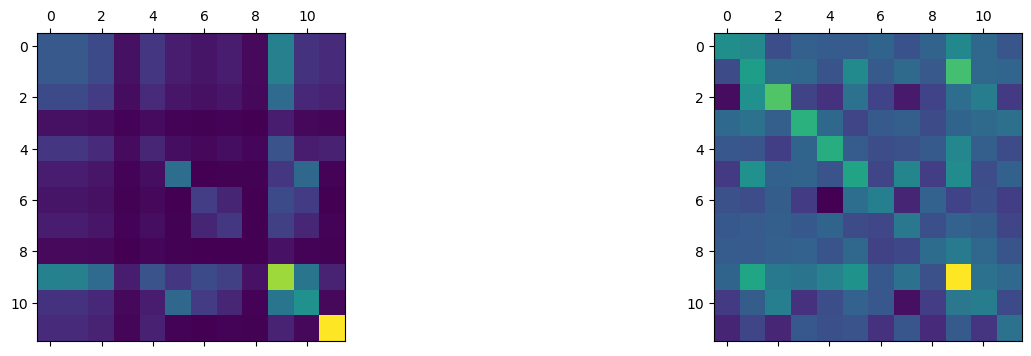

In [ ]:
import matplotlib.pyplot as plt
from random import randint

n = randint(test_start // min(win_sizes), test_end // min(win_sizes))
test_path = os.path.join(matrix_data_path, 'test_data', 'test_data_'+str(n)+'.npy')
r_path = os.path.join(base_path, 'matrix_generator_output', 'datareconstructed_data', 'reconstructed_data_'+str(n)+'.npy')
test = np.load(test_path)
r = np.load(r_path)
r = np.transpose(r[0], [0, 3, 1, 2])

fig, ax = plt.subplots(1,2, figsize=(16,4))
ax[0].matshow(test[4,0])
ax[1].matshow(r[0,0])

# Evaluate: thred_b, threshold grid-search

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def get_best_anomaly_score_v2(test_data_path, reconstructed_data_path, valid_start, valid_end, test_start, test_end, true_valid_labels, true_test_labels, thred_bs, min_valid=None):
  best_valid_f1 = -1
  best_valid_threshold = 0
  best_valid_thred_bs = 0

  best_test_f1 = -1
  best_test_threshold = 0
  best_test_thred_bs = 0

  best_compromise_f1 = -1
  best_compromise_threshold = 0
  best_compromise_thred_bs = 0
  best_compromise_composed = 0
  best_compromise_valid_anomaly_score = None
  best_compromise_test_anomaly_score = None

  for thred_b in thred_bs:
    valid_anomaly_score, test_anomaly_score = calculate_anomaly_scores(test_data_path, reconstructed_data_path, thred_b, valid_start, valid_end, test_start, test_end)
    thresholds = np.linspace(min(valid_anomaly_score), max(valid_anomaly_score)+1, 100)
    for threshold in thresholds:
      valid_prediction = valid_anomaly_score > threshold
      valid_precision = precision_score(true_valid_labels, valid_prediction, average='binary', zero_division=0)
      valid_recall = recall_score(true_valid_labels, valid_prediction, average='binary', zero_division=0)
      valid_f1 = f1_score(true_valid_labels, valid_prediction, average='binary', zero_division=0)

      test_prediction = test_anomaly_score > threshold
      test_precision = precision_score(true_test_labels, test_prediction, average='binary', zero_division=0)
      test_recall = recall_score(true_test_labels, test_prediction, average='binary', zero_division=0)
      test_f1 = f1_score(true_test_labels, test_prediction, average='binary', zero_division=0)
      # print(f"Current thred_b: {thred_b}. Current threshold: {threshold}")
      # print(f"\tValidation F1 ({valid_f1})")
      # print(f"\tValidation Precision ({valid_precision})")
      # print(f"\tValidation Recall ({valid_recall})")
      # print(f"\tTest F1 ({test_f1})")

      if valid_f1 > best_valid_f1:
        best_valid_f1 = valid_f1
        best_valid_threshold = threshold
        best_valid_thred_bs = thred_b
        print(f"~#~ New best F1 score for validation ({best_valid_f1}) thred_b = {thred_b}, threshold = {threshold} ~#~")
        print(f"\tValidation Precision ({valid_precision})")
        print(f"\tValidation Recall ({valid_recall})")
        print(f"\tTest F1 ({test_f1})")

      if test_f1 > best_test_f1:
        best_test_f1 = test_f1
        best_test_threshold = threshold
        best_test_thred_bs = thred_b
        print(f"/#/ New best F1 score for test ({best_test_f1}) thred_b = {thred_b}, = threshold {threshold} /#/")
        print(f"\tTest Precision ({test_precision})")
        print(f"\tTest recall ({test_recall})")
        print(f"\tValid F1: {valid_f1}")

      if min_valid:
        if (valid_f1 > min_valid and (test_f1*valid_f1) > best_compromise_composed):
          best_compromise_f1 = test_f1
          best_compromise_threshold = threshold
          best_compromise_thred_bs = thred_b
          best_compromise_composed = test_f1*valid_f1
          best_compromise_valid_anomaly_score = valid_anomaly_score
          best_compromise_test_anomaly_score = test_anomaly_score
          print(f"\%\ New compromise found: valid f1 = {valid_f1}, test f1 = {best_compromise_f1}. thred_b = {thred_b}, = threshold {threshold} \%\\")


  return best_valid_f1, best_valid_thred_bs, best_valid_threshold, best_test_f1, best_test_thred_bs, best_test_threshold, best_compromise_f1, best_compromise_threshold, best_compromise_thred_bs, best_compromise_valid_anomaly_score, best_compromise_test_anomaly_score

In [ ]:
test_data_path = os.path.join(matrix_data_path, 'test_data/')
reconstructed_data_path = os.path.join(base_path, 'matrix_generator_output/', 'datareconstructed_data/')

train_start, train_end = get_first_and_last_index(matrix_data_path+'/train_data')

true_train_labels, true_valid_labels, true_test_labels, valid_start, valid_end, test_start, test_end = reshape_labels(labels_df, min(win_sizes), train_start, train_split_index, valid_split_index)

Split: train 0.5006211180124224, valid 0.18198757763975154, test 0.3173913043478261
Percentage anomaly train ground-truth set: 2.481389578163772
Percentage anomaly validation ground-truth set: 8.873720136518772
Percentage anomaly test ground-truth set: 9.58904109589041


In [ ]:
# win = [30, 60, 120], stepmax=20
thred_bs = np.linspace(0.00000000001, 0.000001, num=50)

# Set the minimum threshold for validation
min_valid = 0.7  # The compromise should achieve a validation F1 score of at least 70%

best_valid_f1, best_valid_thred_bs, best_valid_threshold, best_test_f1, \
best_test_thred_bs, best_test_threshold, best_compromise_f1, best_compromise_threshold, \
best_compromise_thred_bs, valid_anomaly_score, test_anomaly_score = \
get_best_anomaly_score_v2(test_data_path, reconstructed_data_path, valid_start, valid_end, \
test_start, test_end, true_valid_labels, true_test_labels, thred_bs, min_valid)

~#~ New best F1 score for validation (0.16352201257861634) thred_b = 1e-11, threshold = [137.] ~#~
	Validation Precision (0.08904109589041095)
	Validation Recall (1.0)
	Test F1 (0.17689530685920576)
/#/ New best F1 score for test (0.17689530685920576) thred_b = 1e-11, = threshold [137.] /#/
	Test Precision (0.09702970297029703)
	Test recall (1.0)
	Valid F1: 0.16352201257861634
~#~ New best F1 score for validation (0.1656050955414013) thred_b = 1e-11, threshold = [138.05050505] ~#~
	Validation Precision (0.09027777777777778)
	Validation Recall (1.0)
	Test F1 (0.18081180811808117)
/#/ New best F1 score for test (0.18081180811808117) thred_b = 1e-11, = threshold [138.05050505] /#/
	Test Precision (0.09939148073022312)
	Test recall (1.0)
	Valid F1: 0.1656050955414013
~#~ New best F1 score for validation (0.1750841750841751) thred_b = 1e-11, threshold = [139.02020202] ~#~
	Validation Precision (0.0959409594095941)
	Validation Recall (1.0)
	Test F1 (0.18773946360153254)
/#/ New best F1 score

In [ ]:
print(f"Best F1 for validation {best_valid_f1} thred_b: {best_valid_thred_bs}, threshold {best_valid_threshold}")
print(f"Best F1 for test {best_test_f1} thred_b: {best_test_thred_bs}, threshold {best_test_threshold}")

Best F1 for validation 1.0 thred_b: 1.4286571428571427e-07, threshold [137.82828283]
Best F1 for test 0.7884615384615385 thred_b: 1.8368163265306122e-07, threshold [139.22222222]


# Evaluate

In [ ]:
thred_b = 6.326567346938774e-07
threshold = 134.74747475
alpha=0.93

In [ ]:
valid_anomaly_score, test_anomaly_score = calculate_anomaly_scores(test_data_path, reconstructed_data_path, thred_b, valid_start, valid_end, test_start, test_end)

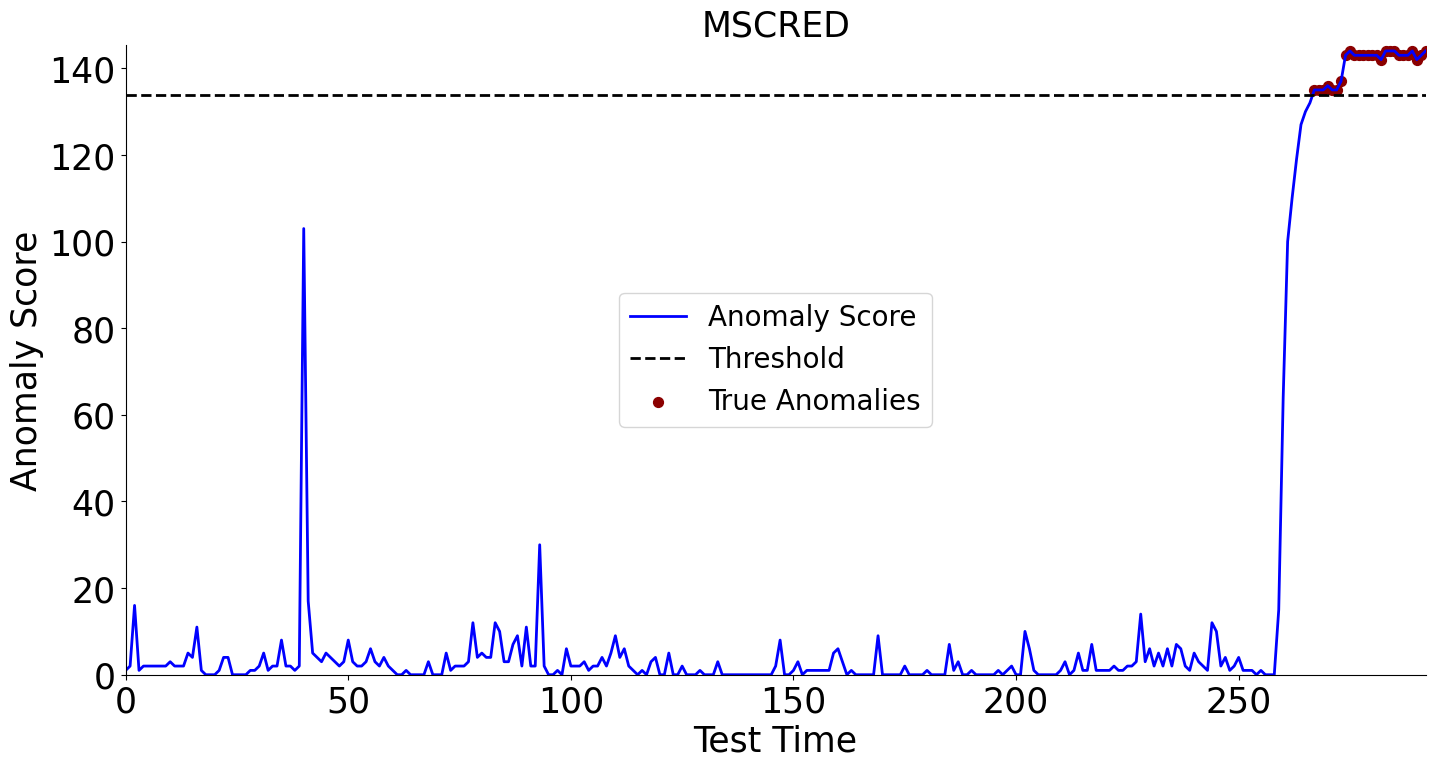

In [ ]:
plot_anomaly_scores(valid_anomaly_score, np.max(valid_anomaly_score), alpha, valid_start, valid_end, true_valid_labels)

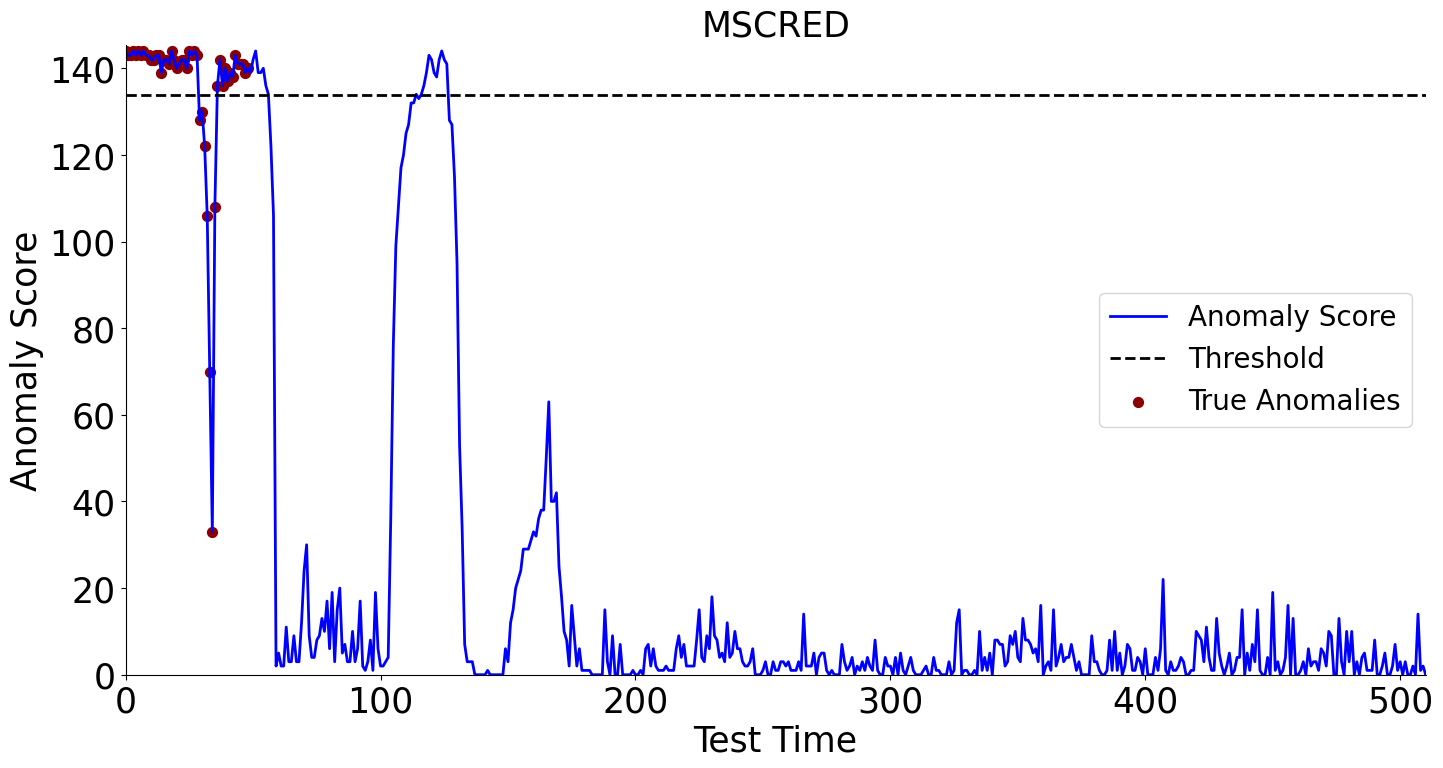

In [ ]:
plot_anomaly_scores(test_anomaly_score, np.max(valid_anomaly_score), alpha, test_start, test_end, true_test_labels)

In [ ]:
true_test_labels[true_test_labels==True].shape

(49,)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

predicted = test_anomaly_score > threshold
precision = precision_score(true_test_labels, predicted)
recall = recall_score(true_test_labels, predicted)
f1 = f1_score(true_test_labels, predicted)
auc_score = roc_auc_score(true_test_labels, predicted)
print(f"Precision: {precision}\nRecall: {recall}\nF1: {f1}\nAUC-ROC Score: {auc_score}")

Precision: 0.711864406779661
Recall: 0.8571428571428571
F1: 0.7777777777777777
AUC-ROC Score: 0.9101731601731602
